# Imports

In [254]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.stats import norm, kendalltau, spearmanr, weightedtau
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime as dt
import os
from tqdm import tqdm

from utilities import exponential, bimodal_exponential_noise, sigmoid
from Code_Ring_Network import CodeRingNetwork

# Parameters

In [294]:
ring_neurons = 36
weight_RC_spread = 0.02

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.0001

min_activity_value = 0.2

noise_num_high = 9
noise_num_low = ring_neurons - noise_num_high
noise_rate_high = 6
noise_rate_low = 12

tmax = 70
tsteps = 700

# Definitions

In [295]:
crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_rate_low=noise_rate_low, noise_rate_high=noise_rate_high,
                    noise_num_low=noise_num_low, noise_num_high=noise_num_high)

ID string: 2024-03-16 153710523328


In [296]:
# def code_spread_metric(code_activity, **metric_kwargs):
#     n = len(code_activity)
#     if code_activity.shape == (n,1):
#         code_activity = code_activity.flatten()
#     num_high = np.count_nonzero(code_activity > metric_kwargs['min_activity_value'])
#     high_idxs = np.argwhere(code_activity > metric_kwargs['min_activity_value']).flatten()
#     spreads = np.zeros((n, n, 2)) + 9999
#     for i in high_idxs:
#         for j in high_idxs:
#             if num_high == np.count_nonzero(code_activity[i:j+1] > metric_kwargs['min_activity_value']):
#                 spreads[i][j][0] = np.abs(i - j) + 1
#             if num_high == np.count_nonzero(np.concatenate((code_activity[0:i+1], code_activity[j:n])) > metric_kwargs['min_activity_value']):
#                 spreads[i][j][1] = n - np.abs(i - j) + 1
#     min_spread = np.min(spreads)
#     top = exponential(min_spread, rate=metric_kwargs['spread_penalty_rate'], center=num_high, init_val=1)
#     bottom = 1 + (metric_kwargs['weight_diff_from_desired']  * np.abs(metric_kwargs['num_desired_high'] - num_high))
#     spread_score = top / bottom
#     print('spread', spread_score)
#     return spread_score

In [297]:
# def kendall_rank_metric(code_activity, **metric_kwargs):
#     # TODO: this still doesn't account for signals that wrap around
#     num_high = np.count_nonzero(code_activity > metric_kwargs['min_activity_value'])
#     high_idxs = np.argwhere(code_activity > metric_kwargs['min_activity_value']).flatten()
#     ideal = np.arange(1, num_high + 1) # values don't matter, just the order
#     kendall = np.abs(kendalltau(code_activity[high_idxs], ideal).statistic)
#     print('kendall', kendall)
#     return kendall

In [298]:
def clockwise_mono_spread_metric(code_activity, **metric_kwargs):
    n = len(code_activity)
    if code_activity.shape == (n,1):
        code_activity = code_activity.flatten()
    num_high = np.count_nonzero(code_activity > metric_kwargs['min_activity_value'])
    high_idxs = np.argwhere(code_activity > metric_kwargs['min_activity_value']).flatten()
    ideal = np.arange(n, 0, -1) # values don't matter, just the order

    # store all scores for each i,j pair, where each pair has a chain forward
    scores = np.zeros((n, n))

    # iterate over left endpoint of chain
    for i in high_idxs:
        # iterate over right endpoints of chain
        for j in high_idxs:
            if i > j:
                spread = n - i + j + 1
                # get all indexes i to n-1, then 0 to j, going fwd
                fwd_idxs_all = np.concatenate((np.arange(i, n), np.arange(0, j+1)))
            else:
                spread = j - i + 1
                # get all indexes i to j going fwd
                fwd_idxs_all = np.arange(i, j + 1)
            # get the indexes of those indexes (therefore, temp indexes) that have a high value
            fwd_high_idxs_temp = np.argwhere(code_activity[fwd_idxs_all] > metric_kwargs['min_activity_value']).flatten()
            # and go back to getting the original index value from those temp indexes
            fwd_high_idxs = fwd_idxs_all[fwd_high_idxs_temp]

            # check that our list of high indexes going forward contains all high values. if not, we skip this chain
            if num_high == len(fwd_high_idxs):
                print(i,j)
                # spread score based on distance going forward
                dist_from_perf_spread = np.abs(spread - num_high)
                print('dist_from_perf_spread: ', dist_from_perf_spread)
                top = exponential(dist_from_perf_spread, rate=metric_kwargs['spread_penalty_rate'], init_val=1)
                bottom = 1 + (metric_kwargs['weight_diff_from_desired']  * np.abs(metric_kwargs['num_desired_high'] - num_high))
                spread_score = top / bottom
                print('spread_score: ', spread_score)

                # kendall score based on chain going forward - since clockwise only, need to normalize kendall to [0,1]
                kendall = (kendalltau(np.roll(code_activity, i), ideal).statistic + 1) / 2
                print('kendall: ', kendall)
                weighted_tau = (weightedtau(np.roll(code_activity, i), ideal, rank=False, weigher=lambda x: int(x < np.finfo(np.float64).eps), additive=True).statistic + 1) / 2
                print('weighted tau: ', weighted_tau)
                spearman = (spearmanr(np.roll(code_activity, i), ideal).statistic + 1) / 2
                print('spearman: ', spearman)

                # weighted average of the two scores
                scores[i][j] = (metric_kwargs['theta'] * spread_score) + ((1 - metric_kwargs['theta']) * kendall)
    
    i, j = np.unravel_index(np.argmax(scores), shape=(n,n))
    max_score = scores[i][j]

    return max_score


In [299]:
spread_penalty_rate = -0.8
weight_diff_from_desired = 0.2
theta = 0.0

num_desired_high = 9

WEIGHTED TAU: 0.7904761904761906 SCORE:  0.0001565615498209177 ROLL:  24
-----------------------------


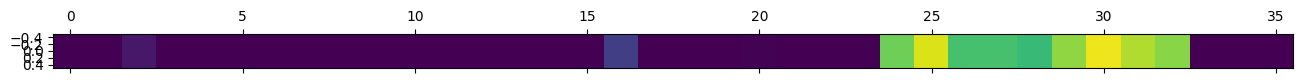

In [300]:
num_high = num_desired_high

# c = np.concatenate((np.linspace(1, 0.2, num_high-2), np.zeros(7), [0.612], np.zeros(10), [0.412], np.zeros(10)))
c = np.roll(bimodal_exponential_noise(num_low=noise_num_low, num_high=noise_num_high, noise_rate_low=noise_rate_low, noise_rate_high=noise_rate_high, shuffle=False), np.random.randint(0,ring_neurons))
c = np.where(c >= min_activity_value, c, 0.0)
ideal = np.arange(ring_neurons, 0, -1)
high_idxs = np.argwhere(c >= min_activity_value).flatten()
wtaus = []
scores = []
for i in range(ring_neurons):
    ideal_rolled = np.roll(ideal, i)
    w = (weightedtau(c, ideal_rolled, rank=False, weigher=lambda x: 1 if x in high_idxs else 0, additive=True).statistic + 1) / 2
    wtaus += [w]
    scores += [sigmoid(w, beta=80, mu=0.9)]

# print(c)
# print(ideal)
# ideal_ranks = np.where(c < min_activity_value, 1, 0)
# print(ideal_ranks)

print('WEIGHTED TAU:', np.max(wtaus), 'SCORE: ', np.max(scores), 'ROLL: ', np.argmax(scores))
print('-----------------------------')
# # c = bimodal_exponential_noise(27,9,6)
# print('score', clockwise_mono_spread_metric(c, 
#                 min_activity_value=min_activity_value,
#                 spread_penalty_rate=spread_penalty_rate,
#                 weight_diff_from_desired=weight_diff_from_desired,
#                 theta=theta,
#                 num_desired_high=num_desired_high))


plt.matshow(c.reshape(1,len(c)), vmin=0.2, vmax=1)


In [301]:
c

array([0.        , 0.        , 0.25018637, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.34894105, 0.        , 0.        , 0.        ,
       0.2060287 , 0.        , 0.        , 0.        , 0.8240587 ,
       0.95884115, 0.76590299, 0.76663519, 0.74297185, 0.86751695,
       0.97894678, 0.90498305, 0.85662915, 0.        , 0.        ,
       0.        ])

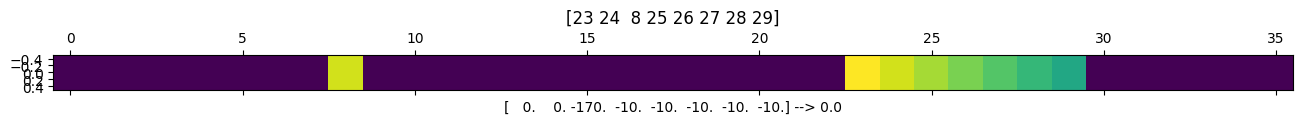

In [302]:
n = 36
delta_angle = 360 / n
num_high_desired = 8
min_activity = 0.2

# c = bimodal_exponential_noise(n-num_high_desired, num_high_desired, 30)
# c = np.where(c > min_activity, c, 0)

c = np.concatenate((np.zeros(14),[0.932] , np.zeros(14),  np.linspace(1,0.6,7)))
r = np.random.randint(0, n)
c = np.roll(c, r)
assert len(c) == n, f'c is length {len(c)}'

active_idxs = np.argwhere(c > min_activity).flatten()
num_high = len(active_idxs)
activity_order = np.flip(np.argsort(c[active_idxs])) # decreasing order, because highest activity fires first
effector_order = active_idxs[activity_order]

init_effector = effector_order[0]
init_angle = init_effector * delta_angle

# check if active zone wraps around past 0 deg. if so, break up chain into 2 parts before combining
if init_angle + (num_high * delta_angle) > 350:
    # get how many steps in 1st part of chain
    steps_from_init_to_0 = (360 - init_angle) / delta_angle
    # get how many steps in 2nd part of chain
    steps_from_0_to_end = num_high - steps_from_init_to_0
    # then combine the two parts
    ideal_angles = np.concatenate((np.arange(init_angle, 360, step=delta_angle), 
                                   np.arange(0, (steps_from_0_to_end * delta_angle), step=delta_angle)))
# else, active zone doesn't wrap around
else:
    ideal_angles = np.arange(init_angle, (init_angle + (num_high * delta_angle)), step=delta_angle)

effector_angles = effector_order * delta_angle
devs = effector_angles - ideal_angles

if ((np.abs(devs) > 20)).any(): score = 0.0
else:
    score = 1.0
    score -= np.count_nonzero(np.abs(devs)==10) * 0.3
    score -= np.count_nonzero(np.abs(devs)==20) * 0.6
    score = np.clip(score, 0, 1)

# penalty_dict = {0: 0.0, 10: -0.3, 20: -0.6} | {k: -1.0 for k in range(30, 360, 10)} | {k: -1.0 for k in range(0, -360, -10)}
# print(devs)
# dev_scores = np.prod(np.clip(2 - np.exp(0.3*((devs/10)**2)), 0, 1))
plt.matshow(c.reshape(1,-1))
plt.title(f'{effector_order}')
plt.xlabel(f'{devs} --> {score}')
plt.show()

In [303]:
    def show_map_results(crn, filename, durations: float, t_max: int, max_t_steps: int, plot_results: bool, **metric_kwargs) -> None:
        '''
        Saves the outputted drawing from each map neuron in one overall figure.

        :param filename str: the filename of the outputted plot
        :param durations float: the durations inputted into the code layer (this is temporary until duration layer is implemented)
        :param t_max int: the maximum time to integrate each iteration over
        :param t_steps int: the number of timesteps to integrate over from [0, t_max]

        :returns: None
        '''
        print('Saving Map Results Plot')
        map_size = crn.map_layer.d1 * crn.map_layer.d2
        fig, axs = plt.subplots(crn.map_layer.d1, crn.map_layer.d2,
                                figsize=(crn.map_layer.d1,crn.map_layer.d2), sharex=True, sharey=True)

        activity_matrix = np.zeros((crn.map_layer.d1, crn.map_layer.d2))
        for i in tqdm(range(map_size)):
            (r, c) = crn.map_layer.convert_to_coord(i)
            activity_matrix[r, c] = 1.0
            code_input = crn.map_layer.weights_to_code_from_map @ activity_matrix.reshape(map_size, 1)

            # top_idxs = np.argsort(code_input.flatten())[-metric_kwargs['num_desired_high']:]
            # code_output = np.zeros((crn.code_layer.num_code_units, 1))
            # code_output[top_idxs] = code_input[top_idxs]
            code_output = np.where(code_input >= metric_kwargs['min_activity_value'], code_input, 0.0)

            # determine output of code layer (input into ring layer)
            ring_input = crn.code_layer.weights_to_ring_from_code @ code_output

            # determine activity of duration layer
            # TODO: right now, this is just a constant
            dur_output = crn.duration_layer.activate(durations)

            # integrate ring layer model over time
            v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=t_max, t_steps=max_t_steps)

            # limit t_steps to end of integration
            t_steps = z_series.shape[1]

            # apply model results to the drawing system
            x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

            # evaluate drawing
            # score, curvatures, intersec_pts, intersec_times = crn.evaluate(x_series, y_series, t_steps=t_steps, **metric_kwargs)
            score = crn.eval_code_activity(code_output, **metric_kwargs)
            intersec_pts = np.ndarray((0,2))
            intersec_times = np.array([])

            # determine the most similar neuron to the activity of the code layer
            map_winner = crn.map_layer.forward(code_output)
            winner_idx = crn.map_layer.convert_to_index(map_winner)

            # plot ring layer variables over time
            plot_v = v_series if crn.vars_to_plot['v'] else []
            plot_u = u_series if crn.vars_to_plot['u'] else []
            plot_z = z_series if crn.vars_to_plot['z'] else []
            plot_I_prime = I_prime_series if crn.vars_to_plot['I_prime'] else []
            if plot_results:
                crn.plot_results(xs=x_series, ys=y_series, intersec_pts=intersec_pts,
                            ring_inputs=ring_input,
                            v=plot_v, u=plot_u, z=plot_z, I_prime=plot_I_prime,
                            folder_name=crn.folder_name,
                            epoch=filename.split('\\')[-1].split('.')[0], iteration=i,
                            active_idx=i, winner_idx=winner_idx,
                            score=score, plot_gif=False, idx_folders=True)
                                            
            # generate drawing for current neuron
            crn.plot_final_doodle(ax=axs[r][c], xs=x_series, ys=y_series, intersec_pts=intersec_pts, individualize_plot=False)
            axs[r][c].set_xlim([-100,100])
            axs[r][c].set_ylim([-100,100])
            axs[r][c].set_xlabel(f'{np.round(score,3)}')
            axs[r][c].set_box_aspect(1)

            # reset active neuron to inactive
            activity_matrix[r, c] = 0.0

        plt.tight_layout()
        fig.savefig(filename)
        plt.close(fig)


In [304]:
crn = CodeRingNetwork(num_ring_units=36, num_code_units=36, code_factor=1, num_dur_units=36,
                 map_d1=12, map_d2=12, code_ring_spread=0.02,
                 noise_rate=8, noise_num_high=8)
crn.map_layer.weights_to_code_from_map = crn.load_model_params('C:\\Users\\Robbie\\Documents\\Documents\\Research\\Code_Ring_Network\\Code-Ring-Network\\output\\2024-03-07 205631235498\\weights_2024-03-07 205631235498_theta0p25.xlsx')
crn.map_layer.weights_to_map_from_code = crn.map_layer.weights_to_code_from_map.T

min_activity_value = 0.05
spread_penalty_rate = -0.05
weight_diff_from_desired = 0.2
num_desired_high = 8
theta = 0.25

show_map_results(crn, 'results from full code activity trial', 0.2,70,700,False,
                    min_activity_value=min_activity_value,
                    spread_penalty_rate=spread_penalty_rate,
                    weight_diff_from_desired=weight_diff_from_desired,
                    theta=theta,
                    num_desired_high=num_desired_high)


ID string: 2024-03-16 153711384091


KeyError: 'noise_rate_low'